In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.6.0
MPS available: True


# Building a Score-Based Diffusion Model with MNIST

## Project Objectives & Overview

In this notebook, I'll document my process of building a score-based diffusion model that can generate numbers from the MNIST dataset. Learn through doing!

This implementation builds upon our previous simple <b>DDPM ("Denoising Diffusion Probabilistic Model")</b> approach, adapting it to the more mathematically elegant <b>score-based framework</b>. Like our DDPM, this model removes noise from random input images without any conditioning or optimizations. It's primarily a learning exercise to understand the fundamentals of score-based diffusion models.

### The difference

My previous DDPM implementation worked by:

1. Gradually adding noise to images using a discrete Markov chain process
2. Training a neural network to predict the noise that was added at each discrete timestep
3. Reversing the process by iteratively removing predicted noise

The score-based approach transforms this discrete process into a continuous one:

1. Formulating the noise addition as a continuous stochastic differential equation (SDE)
2. Training a neural network to predict the score function (gradient of log probability density) rather than the noise itself
3. Using various numerical solvers (SDE/ODE solvers) for the reverse process
4. This shift from discrete to continuous mathematics provides several significant advantages:

### Why both?

#### Visual Differences in Generated Samples

In terms of final output quality, we may not see dramatic differences with MNIST specifically, because MNIST is relatively simple (black and white digits, minimal complexity), and both models can ultimately achieve good results on this dataset. This transition from discrete to continuous mathematics offers significant advantages while maintaining the core intuition of noise transformation.

Subtle things we may notice:

- Potentially sharper edges in some cases with score-based models
- Better handling of ambiguous digits (like 4/9 or 3/8) where the distribution is multi-modal
- More natural variations in generated samples (less artificial noise artifacts)

Practically speaking, the advantages may be:

1. Sampling Flexibility (most noticeable) - we'd be able to sample from any arbitrary point in the reverse process! This means:

- You could start sampling from t=150.75 instead of just t=150
- You could use adaptive step sizes (smaller steps for critical parts of digit formation, larger steps elsewhere)
- You could compare different sampling trajectories from the same starting noise

2. Significantly Faster Sampling
   This is perhaps the biggest practical benefit - The previous DDPM requires 300 sequential steps for each sample. With score-based models using probability flow ODEs, you might generate comparable quality with 20-50 steps, which could speedup the generation time by 5-10x! Maybe I could demonstrate this with a chart showing generation time vs. sample quality - Let's see.

3. Experimentation Options
   You'd gain the ability to:

- Try different numerical solvers and compare their outputs
- Generate intermediate samples at arbitrary time points
- Explore the trade-off between speed and quality more flexibly

## DDPM vs. Score-Based Models Comparison

| Aspect                     | DDPM (Discrete)                                    | Score-Based Models (Continuous)                                       | Benefits of Score-Based Approach                                                                                                                                                            | Limitations Overcome                                                                        |
| -------------------------- | -------------------------------------------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| **Time Representation**    | Fixed numbered steps (t=0, t=1, t=2... t=300)      | Continuous time values (t can be any value between 0 and T)           | • More flexible sampling<br>• Can use adaptive step sizes<br>• Enables mathematical speedup techniques                                                                                      | Overcomes the rigid structure of fixed steps, allowing efficiency optimizations             |
| **Mathematical Framework** | Sequence of explicit noise-adding formulas         | Stochastic Differential Equations (SDEs)                              | • More elegant mathematical foundation<br>• Connections to other math fields<br>• More options for solving reverse process<br>• Clearer theoretical properties                              | Replaces somewhat arbitrary discrete construction with well-studied mathematical properties |
| **Learning Target**        | Predicts "what noise was added"                    | Predicts "which direction increases data likelihood" (score function) | • Directly relates to underlying data distribution<br>• Clearer conceptual framework<br>• Better connections with other generative approaches<br>• Better handling of complex distributions | Moves from indirect noise prediction to direct modeling of data distribution                |
| **Sampling Flexibility**   | Fixed algorithm that must follow all reverse steps | Various numerical solvers (Euler-Maruyama, Predictor-Corrector, etc.) | • Speed vs. quality tradeoffs<br>• Advanced numerical methods<br>• Potentially much faster sampling (ODEs)<br>• Easier adaptation to different data types                                   | Addresses unnecessary slowness of DDPM sampling with adaptive approaches                    |
| **Implementation Changes** | N/A                                                | U-Net architecture stays similar, but training and sampling change    | • Leverage existing architecture<br>• Main changes in math interpretation<br>• More flexibility without complete rewrite                                                                    | Maintains strengths while addressing weaknesses, particularly sampling speed                |

## Mathematical Foundations

### Stochastic Differential Equations (SDEs)

The forward process is modeled as a continuous SDE:

dx = f(x,t)dt + g(t)dw

Where:

- f(x,t) is the drift term (deterministic component)
- g(t) is the diffusion coefficient
- dw is a standard Wiener process (Brownian motion)

This formulation precisely controls how data transforms into noise through continuous time rather than discrete steps.

### The Score Function

The core innovation is predicting the score function - the gradient of the log probability density:

∇x log p(x)

This function points toward regions of higher data probability density, directly guiding the model in generating realistic images.

## Implementation Requirements

To transform our DDPM into a score-based model, I'll need to make these key modifications:

1. **SDE Formulation**: Replace discrete beta schedule with continuous SDE coefficients
2. **Score Matching Loss**: Implement denoising score matching rather than noise prediction
3. **Numerical Solvers**: Create SDE/ODE solvers for the reverse process
4. **Network Adaptation**: Adjust the U-Net to predict the score instead of noise
5. **Continuous Time**: Update time embeddings and sampling to work with continuous values

These changes will enable:

- Starting generation from any arbitrary timepoint
- Using adaptive step sizes for efficiency
- Leveraging probability flow ODEs for faster sampling
- Applying various numerical methods with different quality/speed tradeoffs

## Dataset Information

- **Name**: MNIST Database of handwritten digits
- **Source**: MNIST Dataset
- **Format**: 28×28 grayscale images of handwritten digits (0-9)

### Implementation Notes

This implementation adapts the score-based diffusion model architecture to work with:

- TGA format images (using PIL for loading)
- Apple Silicon hardware (ensuring MPS device compatibility)

### Credits and References

This implementation builds upon our previous DDPM work and takes inspiration from:

- Song, Y., et al. (2021). "Score-Based Generative Modeling through Stochastic Differential Equations"
- Yang, L., & Zhang, Z. (2022). "Diffusion Models: A Comprehensive Survey of Methods and Applications"
- Karras, T., et al. (2022). "Elucidating the Design Space of Diffusion-Based Generative Models"

The original DDPM work referenced:

- "Denoising Diffusion Probabilistic Models" (Ho et al., 2020)
- "Improved Denoising Diffusion Probabilistic Models" (Nichol & Dhariwal, 2021)


# Load dataset


In [3]:
from torchvision import datasets, transforms

# Load MNIST dataset

# Define transformations for MNIST dataset
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor (0,1)
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
    ]
)

data_dir = "./data/"
data = datasets.MNIST(
    root=data_dir, train=True, transform=data_transforms, download=True
)

In [4]:
# Functions to read Image & Label from given file path
def read_idx_images(file_path):
    """Reads an IDX image file and returns a tensor of shape (N, 28, 28)"""
    with open(file_path, "rb") as f:
        f.read(4)  # Skip magic number
        num_images = int.from_bytes(f.read(4), "big")
        rows = int.from_bytes(f.read(4), "big")
        cols = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return torch.tensor(data, dtype=torch.float32)  # Convert to float


def read_idx_labels(file_path):
    """Reads an IDX label file and returns a tensor of shape (N,)"""
    with open(file_path, "rb") as f:
        f.read(4)  # Skip magic number
        num_labels = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return torch.tensor(data, dtype=torch.long)  # Convert to long tensor

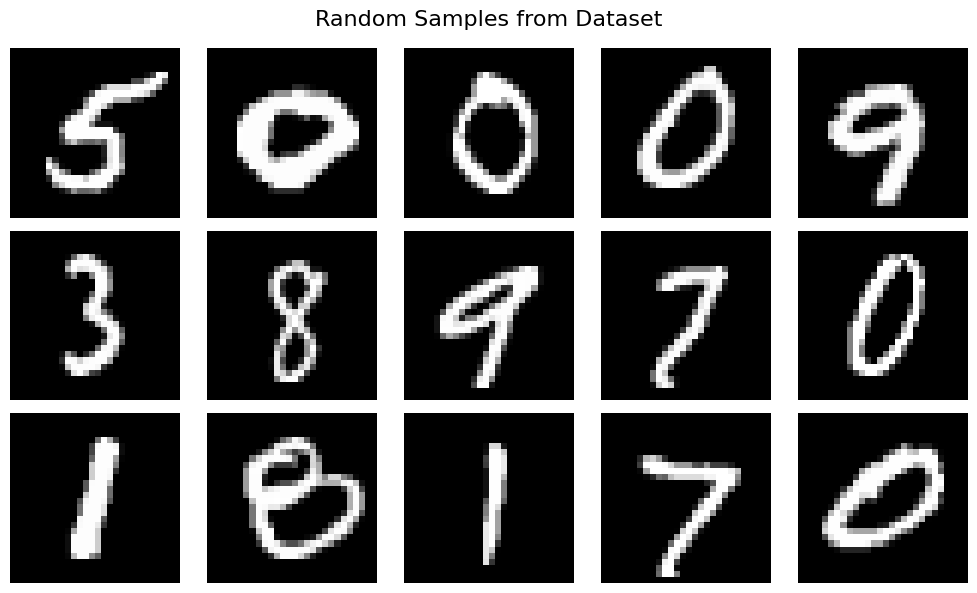

In [5]:
# Assuming read_idx_images loads a tensor of shape (N, 28, 28)
dataset_root_path = "./data/MNIST/raw/t10k-images-idx3-ubyte"
dataset = read_idx_images(dataset_root_path)  # Should return a (N, 28, 28) tensor

# Select 15 random indices
num_samples = 15
random_indices = torch.randint(0, len(dataset), (num_samples,))  # Random indices
dataset_sample = dataset[random_indices]  # Get the images

# Display the images
fig = plt.figure(figsize=(10, 6))

for i, image in enumerate(dataset_sample):
    plt.subplot(3, 5, i + 1)  # Use 3x5 grid
    plt.imshow(image.numpy(), cmap="gray")  # Convert tensor to NumPy
    plt.axis("off")

fig.suptitle("Random Samples from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

Using device: mps


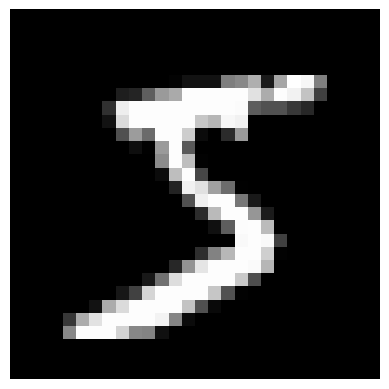

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

# Check for MPS availability
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 28  # MNIST images are 28x28
BATCH_SIZE = 256

# Define transformations for MNIST dataset
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor (0,1)
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
    ]
)

# Configure DataLoader
dataloader = DataLoader(
    data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=0,  # Avoid pickle issues with multiple workers
)


# Function to show a single tensor image
def show_tensor_image(image):
    """
    Display a tensor as an image
    """
    # Remove batch dimension
    if len(image.shape) == 4:  # [B, C, H, W]
        image = image.squeeze(0)  # → [C, H, W]

    # For grayscale (MNIST) images
    if image.shape[0] == 1:  # [1, H, W]
        image = image.squeeze(0)  # → [H, W]

    # Scale from [-1, 1] to [0, 1]
    image = (image + 1) / 2

    # Convert to numpy for display
    image_np = image.numpy()

    # Display as grayscale
    plt.imshow(image_np, cmap="gray")
    plt.axis("off")


# Function to move batch to device efficiently
def prepare_batch(batch, target_device=device):
    return batch[0].to(target_device)  # Only move image tensors (ignore labels)


# Test: Display a sample image from the dataset
sample_image, _ = data[0]  # Get first image

show_tensor_image(sample_image)

# SDE Formulation, SDE-Solvers, and Samplers - Oh My!

## Conceptual Shift from DDPM to Score-Based Models

Score-based diffusion models represent a fundamental shift from the discrete-time Markov chains used in DDPMs to continuous-time stochastic processes. This change offers several theoretical and practical advantages while maintaining the core idea of gradually transforming data through noise addition.

## Components of Score-Based Diffusion Models

| Component                         | Definition                                                                           | Purpose                                                                                                | Examples in Code                                                                          |
| --------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------- |
| **SDE**                           | Mathematical equation defining how data evolves over continuous time with randomness | Defines the forward process of adding noise to data; specifies transformation from clean data to noise | `sde_drift_diffusion_coef()` with options "ve", "vp", "subvp"                             |
| **SDE Solver**                    | Numerical method to approximate solutions to SDEs                                    | Discretizes continuous time into manageable steps; simulates both forward and reverse processes        | Euler-Maruyama method implemented within samplers                                         |
| **Sampler** (appears later)       | Algorithm that generates new data samples using the trained model                    | Implements the reverse process from noise to data; uses model's score estimates to guide generation    | `euler_maruyama_sampler()` (stochastic), `probability_flow_ode_sampler()` (deterministic) |
| **Loss Function** (appears later) | Mathematical formulation quantifying how well the model is learning                  | Guides the training process; teaches the model to estimate the score function                          | `loss_function()` implementing denoising score matching                                   |

### Relationships Between Components

The SDE defines what to solve, while the solver determines how to solve it numerically. The SDE formulation directly affects how the loss function is constructed. During generation, the sampler combines the trained model with an SDE solver to implement the reverse process, applying specific modifications for generation purposes. All these components work together in a pipeline: the SDE defines the noise process, the loss function trains the model to learn this process, and the samplers use the trained model to reverse the process and generate new data.

## SDE Formulation

Unlike DDPMs which use a fixed sequence of discrete steps, score-based models formulate the forward process as a Stochastic Differential Equation (SDE). This continuous formulation allows us to:

1. **Define the process at any arbitrary time point** between 0 and 1, not just at predefined steps
2. **Apply more sophisticated numerical methods** for both training and sampling
3. **Establish stronger theoretical connections** to other generative modeling approaches

The most common SDEs used in score-based models include:

- **Variance Exploding (VE) SDE**: Keeps the data mean constant while increasing the variance over time
- **Variance Preserving (VP) SDE**: Similar to DDPM but in continuous time, preserving the overall variance
- **Sub-VP SDE**: A hybrid approach with intermediate properties

Each formulation offers different trade-offs in terms of sample quality and sampling efficiency.

| SDE Type                 | Mathematical Form                 | Sample Quality   | Sampling Speed   | Training Stability | Best Use Cases                                                       |
| ------------------------ | --------------------------------- | ---------------- | ---------------- | ------------------ | -------------------------------------------------------------------- |
| Variance Exploding (VE)  | dx = σ(t) dw                      | Moderate         | Faster           | Higher             | Simple datasets, initial experiments, when stability matters         |
| Variance Preserving (VP) | dx = -0.5β(t)x dt + √β(t) dw      | Higher           | Slower           | Lower              | Complex datasets, when sample quality is priority, production models |
| Sub-VP                   | dx = -0.5β(t)(1+γ)x dt + √β(t) dw | Adjustable via γ | Adjustable via γ | Moderate           | When fine-tuning the quality/speed tradeoff is needed                |

Key Distinctions:

- VE-SDE: Simpler math, keeps data mean fixed, variance grows unbounded. More stable but potentially lower quality.
- VP-SDE: Controls both mean and variance, converges to standard normal. Better for complex data but requires careful tuning.
- Sub-VP SDE: Generalizes VP with parameter γ, allowing controlled balance between drift and diffusion for customized performance.

For MNIST, the simpler VE-SDE may be sufficient given the dataset's simplicity.

## Continuous Noise Schedule

Instead of a discrete sequence of noise levels, score-based models use a continuous function σ(t) that maps time t ∈ [0,1] to a noise level. Common choices include:

- **Exponential schedules**: σ(t) = σ_min \* (σ_max/σ_min)^t
- **Cosine schedules**: Using cosine functions for smoother transitions
- **Linear schedules**: Simple linear interpolation between min and max values

The continuous nature of this schedule allows for adaptive time stepping during sampling, concentrating computational effort where it's most needed.

## Score Function Estimation

The central difference in score-based models is the training objective. Rather than predicting the added noise directly (as in DDPM), the model is trained to estimate the score function:

- **Score function**: ∇_x log p(x_t) - the gradient of the log probability density
- **Relationship to noise**: In certain SDEs, the score is proportional to the negative of the noise

The "score" is not a performance metric or evaluation measure. It's a mathematical concept from statistics - <br>
In plain terms: The score is the gradient (direction of steepest increase) of the log probability density function with respect to the data. The score measures how the log probability density changes as you move in different directions from a given point in the data space. It points in the direction where the probability density increases most rapidly. Think of it as an arrow at each point in space that:

- Points toward regions of higher probability (where data is more likely)
- Points away from regions of lower probability (where data is less likely)

To compare it to DDPM:
In DDPM:<br>

- The model predicts the noise that was added<br>
- This is an indirect way to estimate the score<br>

In Score-based models:<br>

- The model directly predicts the score<br>
- This is mathematically equivalent in some cases but offers a more general framework

Specific to MNIST, at <b>high noise</b> levels, the score gently guides the process toward "digit-like" structures, at <b>medium noise</b> levels, the score helps define the specific digit shape, at <b>low noise</b> levels, the score refines details like stroke width

## Sampling with Numerical Solvers

Continuous sampling refers to generating samples using the continuous-time formulation of diffusion models, where time t is treated as a real-valued parameter in [0,1] rather than discrete steps. The continuous formulation enables more sophisticated sampling strategies:

- **SDE solvers**:
  - Euler-Maruyama: (The simplest method, similar to discrete DDPM but with flexible step sizes) (More accurate than simple methods, requires more score function evaluations)
  - Stochastic Runge-Kutta methods: Higher-order methods for stochastic differential equations (More accurate per step, more complex to implement)
- **Predictor-corrector methods**: First predicts the next state, then corrects it using the score function, combining deterministic predictions with stochastic corrections (More accurate than simple methods, requires more score function evaluations)
- **Probability flow ODE**: Converts the stochastic process (SDE) to a deterministic one ODE for faster sampling (Faster and more stable, Sometimes produces slightly lower quality samples)

Key Differences from Discrete Sampling
| Discrete Sampling (DDPM) | Continuous Sampling (Score-Based) |
|--------------------------|-----------------------------------|
| Fixed number of predetermined steps | Flexible time steps that can be adapted |
| Each step follows the same update rule | Steps can use different numerical methods based on local behavior |
| Typically uses 1000+ steps for quality | Can often achieve similar quality with fewer function evaluations |

These numerical methods can adapt their step sizes based on local error estimates, potentially reducing the number of function evaluations needed for high-quality samples.

## Benefits of the Score-Based Approach

1. **Theoretical elegance**: Cleaner mathematical formulation with connections to statistical physics
2. **Flexibility in sampling**: Can use various numerical methods with different speed/quality trade-offs
3. **Adaptive computation**: Can concentrate computational effort where the dynamics are changing rapidly
4. **Controllable generation**: Easier to incorporate guidance and conditioning mechanisms
5. **Consistency**: The continuous formulation ensures consistency across different discretization schemes

The score-based approach maintains the impressive generation capabilities of DDPMs while offering a more flexible and theoretically grounded framework that opens up new possibilities for both research and applications.

## SDE Functions (Forward Process)

1. **`noise_schedule()`**: Defines the continuous noise level as a function of time t
2. **`sde_drift_diffusion_coef()`**: Calculates the drift and diffusion coefficients for different SDE types (VE, VP, Sub-VP)
3. **`forward_diffusion_sample()`**: Implements the forward diffusion process for different SDE types
4. **`score_function_from_noise()`**: Converts predicted noise to score function

## SDE Solvers (Reverse Process)

1. **`euler_maruyama_sampler()`**: Implements the Euler-Maruyama method for solving the reverse SDE

   - Stochastic solver
   - Uses the formula: x*t + reverse_drift * dt + sqrt(dt) \_ diffusion \* random_noise

2. **`probability_flow_ode_sampler()`**: Implements the probability flow ODE solver
   - Deterministic solver
   - Uses the formula: x_t + ode_drift \* dt

This gives you flexibility to experiment with different SDE formulations and sampling strategies to find the optimal approach.


In [7]:
import torch
import torch.nn.functional as F


def noise_schedule(t, sigma_min=0.01, sigma_max=1.0):
    """
    Continuous noise schedule function that maps time t ∈ [0,1] to noise level.
    Uses exponential interpolation between min and max noise levels.

    Args:
        t: Time values in [0,1]
        sigma_min: Minimum noise level
        sigma_max: Maximum noise level

    Returns:
        Noise level at time t
    """
    # Handle batched or single t
    t = torch.as_tensor(t)

    # Exponential interpolation between sigma_min and sigma_max
    return sigma_min * (sigma_max / sigma_min) ** t


def sde_drift_diffusion_coef(x, t, sde_type="ve"):
    """
    Returns the drift and diffusion coefficients for different SDE types.

    Args:
        x: Input data
        t: Time values in [0,1]
        sde_type: One of "ve" (Variance Exploding), "vp" (Variance Preserving),
                  or "subvp" (Sub-Variance Preserving)

    Returns:
        drift: Drift coefficient
        diffusion: Diffusion coefficient
    """
    if sde_type == "ve":
        # Variance Exploding SDE: dx = sigma(t) dw
        drift = torch.zeros_like(x)
        diffusion = noise_schedule(t)

    elif sde_type == "vp":
        # Variance Preserving SDE: dx = -0.5 * beta(t) * x dt + sqrt(beta(t)) dw
        beta_t = noise_schedule(t) ** 2  # Using sigma^2 as beta
        drift = -0.5 * beta_t * x
        diffusion = torch.sqrt(beta_t)

    elif sde_type == "subvp":
        # Sub-Variance Preserving SDE with gamma parameter
        gamma = 0.1  # Adjustable parameter
        beta_t = noise_schedule(t) ** 2
        drift = -0.5 * beta_t * (1 + gamma) * x
        diffusion = torch.sqrt(beta_t)

    else:
        raise ValueError(f"Unknown SDE type: {sde_type}")

    return drift, diffusion


def forward_diffusion_sample(x_0, t, sde_type="ve", device="mps", noise=None):
    """
    Takes an image and a time value as input and returns the noisy version of it
    using the specified SDE formulation.

    Args:
        x_0: Original clean image
        t: Time values in [0,1]
        sde_type: SDE formulation to use
        device: Device to run computation on
        noise: Optional pre-generated noise

    Returns:
        x_t: Noisy image at time t
        noise: The noise that was added
    """
    # Ensure t is properly shaped for broadcasting
    t = torch.as_tensor(t).reshape(-1, 1, 1, 1).to(device)
    x_0 = x_0.to(device)

    # Generate noise if not provided
    if noise is None:
        noise = torch.randn_like(x_0).to(device)

    if sde_type == "ve":
        # Variance Exploding: Simple scaling of noise
        sigma_t = noise_schedule(t).to(device)
        x_t = x_0 + sigma_t * noise

    elif sde_type == "vp":
        # Variance Preserving: Similar to DDPM but continuous
        sigma_t = noise_schedule(t).to(device)
        alpha_t = torch.sqrt(1 - sigma_t**2).to(device)
        x_t = alpha_t * x_0 + sigma_t * noise

    elif sde_type == "subvp":
        # Implementation would be similar to VP but with adjusted coefficients
        # For simplicity, we'll use the same implementation as VP for now
        sigma_t = noise_schedule(t).to(device)
        alpha_t = torch.sqrt(1 - sigma_t**2).to(device)
        x_t = alpha_t * x_0 + sigma_t * noise

    else:
        raise ValueError(f"Unknown SDE type: {sde_type}")

    return x_t, noise

## Noise Demonstration


# Continuous Diffusion Process Visualization

This visualization displays the forward diffusion process applied to MNIST digits using a continuous-time score-based diffusion model. Each row shows a different randomly selected digit from the dataset, while columns represent progressive time points in the continuous diffusion process.

Moving from left to right along each row, you see how the diffusion model gradually adds more noise to the original clean images according to the selected SDE formulation. The leftmost column shows the original, unmodified MNIST digits in their clean state. As you move right, each subsequent image shows the same digit with increasing amounts of random noise applied according to a continuous time parameter t ∈ [0,1].

## Expected Behavior for Different SDE Types

| SDE Type                 | Visual Characteristics                                                                                                                                                       | Mathematical Significance                                                         | Training Implications                                                                                      | Sampling Benefits                                                                         |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| Variance Exploding (VE)  | Noise gradually increases while digit structure remains faintly visible even at t=1.0. Note: although relatively visible, upsampling would always begin from complete noise. | Preserves the mean of the data distribution while variance grows without bound    | Model learns to estimate score function where original signal is never completely destroyed                | More stable sampling, especially in early iterations, as mean structure provides guidance |
| Variance Preserving (VP) | Digit gradually transforms into pure Gaussian noise with no trace of original structure at t=1.0                                                                             | Both mean and variance are controlled, converging to standard normal distribution | Model must learn to recover structure from complete noise (more challenging but potentially more powerful) | Often produces higher quality samples as model learns to generate structure from scratch  |
| Sub-VP                   | Shows behavior between VE and VP, with adjustable preservation of structure based on γ parameter                                                                             | Provides controllable interpolation between VE and VP behaviors                   | Allows tuning the difficulty of the learning task based on dataset complexity                              | Offers customizable trade-off between sampling speed and sample quality                   |

## Significance in the Model

The choice of SDE formulation affects several key aspects of the diffusion model:

1. **Training Objective**: The score matching loss is calculated differently depending on the SDE type, affecting how the model learns to estimate gradients of the data distribution

2. **Sampling Procedure**: Different numerical solvers work better with different SDE types - VP often works well with probability flow ODE solvers, while VE may benefit from stochastic samplers

3. **Computational Efficiency**: VE-SDE may require fewer function evaluations during sampling as the structure is never completely destroyed

4. **Sample Quality**: VP-SDE often produces higher quality samples at the cost of more sampling steps

Understanding these different forward processes is crucial because training a score-based diffusion model involves teaching a neural network to estimate the score function (gradient of log probability) at each noise level, which then guides the reverse process - starting from noise and progressively recovering structure to generate new, realistic handwritten digits.


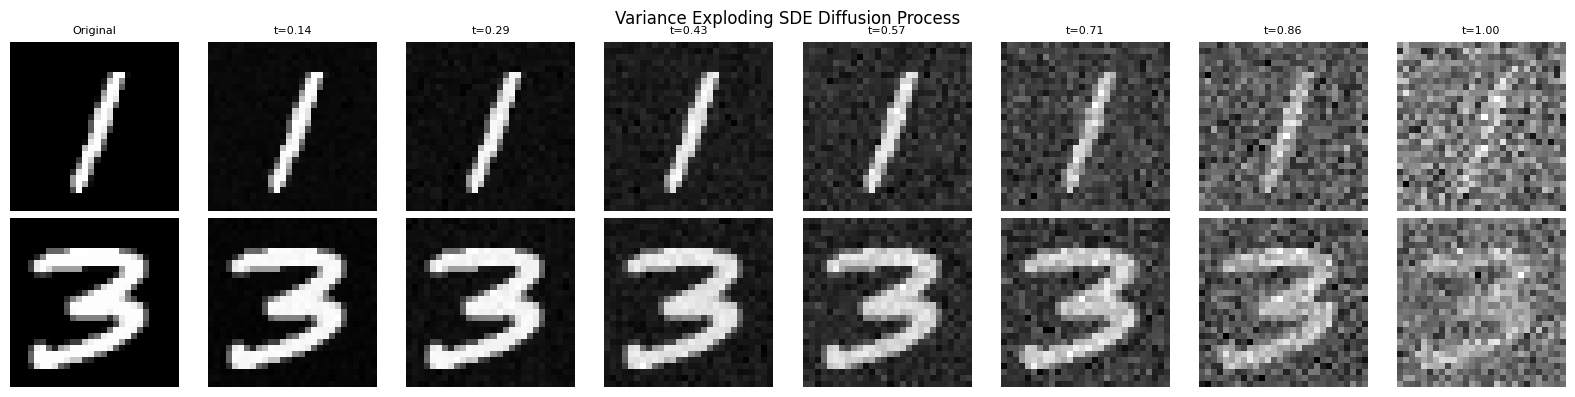

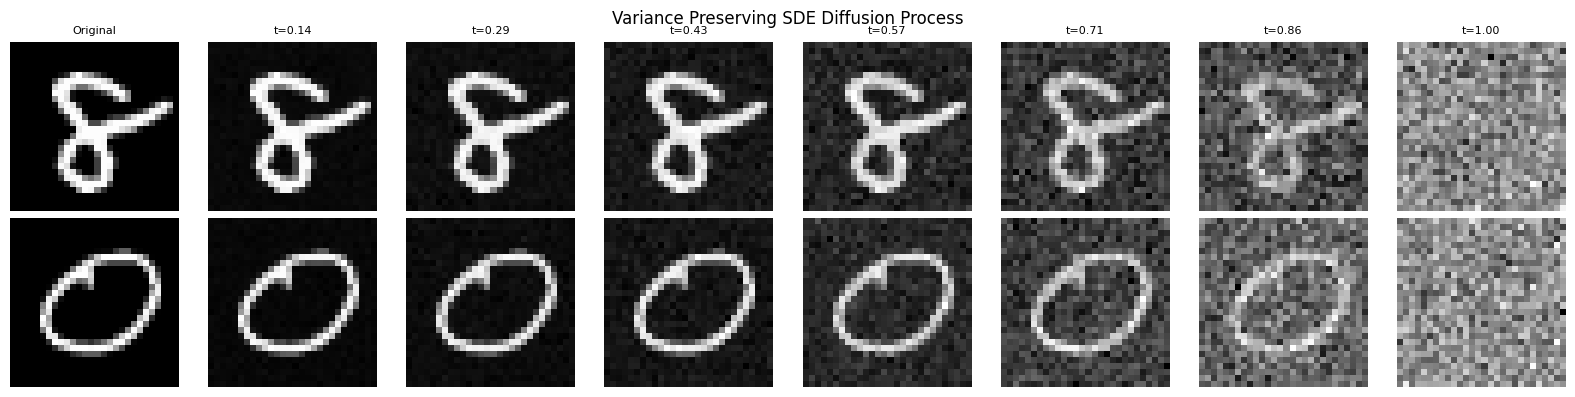

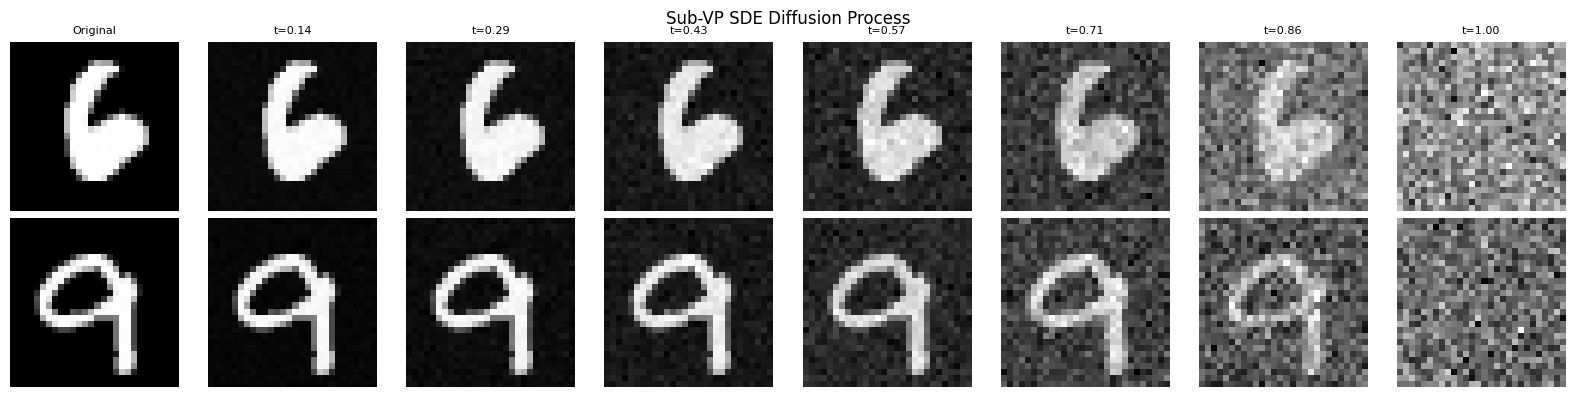

In [8]:
def display_images_with_continuous_diffusion(
    dataloader, num_images=3, num_steps=7, sde_type="ve", device="mps"
):
    """
    Display a grid of randomly selected images with the continuous diffusion process applied.
    Each row shows one image progressively diffused with noise from left to right.
    The first column shows the original, unmodified image.

    Args:
        dataloader: PyTorch dataloader containing the dataset
        num_images: Number of different images to display (rows)
        num_steps: Number of diffusion steps to display (not including original)
        sde_type: Type of SDE to use ("ve", "vp", or "subvp")
        device: Device to run computations on
    """
    # Get a batch of images
    batch = next(iter(dataloader))

    # Move batch to device
    batch = prepare_batch(batch, device)

    # Create figure
    fig, axes = plt.subplots(
        num_images, num_steps + 1, figsize=((num_steps + 1) * 2, num_images * 2)
    )

    # Get random indices from the batch
    batch_size = batch.shape[0]
    indices = np.random.choice(batch_size, size=num_images, replace=False)

    # Calculate the time values for diffusion steps (from 0 to 1)
    time_values = torch.linspace(0, 1, num_steps + 1)

    # Plot each selected image with different noise levels
    for row, idx in enumerate(indices):
        # Get the original image
        original_img = batch[idx].unsqueeze(0)  # Add batch dimension
        original_display = original_img.squeeze(0)  # Ensure shape is (H, W)

        # First, display the original image with no noise
        ax = axes[row, 0]  # First column
        ax.imshow(original_display.squeeze(0).cpu().numpy(), cmap="gray")
        ax.axis("off")

        if row == 0:
            ax.set_title("Original", fontsize=8)

        # Apply different levels of noise for the remaining columns
        for col in range(num_steps):
            ax = axes[row, col + 1]  # Remaining columns
            ax.axis("off")

            # Get time value (skip t=0 as it's the original image)
            t = time_values[col + 1].item()
            t_tensor = torch.tensor([t], device=device)

            # Apply forward diffusion with current time
            noisy_img, _ = forward_diffusion_sample(
                original_img, t_tensor, sde_type=sde_type, device=device
            )
            noisy_img = noisy_img.squeeze().cpu().numpy()  # Ensure shape is (H, W)

            # Display the image
            ax.imshow(noisy_img, cmap="gray")

            # Add time value as title for the first row
            if row == 0:
                # Format time value to 2 decimal places
                ax.set_title(f"t={t:.2f}", fontsize=8)

    # Add SDE type as overall title
    sde_names = {
        "ve": "Variance Exploding",
        "vp": "Variance Preserving",
        "subvp": "Sub-VP",
    }
    plt.suptitle(
        f"{sde_names.get(sde_type, sde_type)} SDE Diffusion Process", fontsize=12
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    plt.show()


# Usage example
display_images_with_continuous_diffusion(
    dataloader, num_images=2, num_steps=7, sde_type="ve"
)

display_images_with_continuous_diffusion(
    dataloader, num_images=2, num_steps=7, sde_type="vp"
)

display_images_with_continuous_diffusion(
    dataloader, num_images=2, num_steps=7, sde_type="subvp"
)

# The Reverse Diffusion Process and U-Net Architecture for Score-Based Models

While the forward diffusion process gradually adds noise to images according to our chosen SDE, the reverse diffusion process is where we generate new images by progressively removing noise. In score-based diffusion models, this process differs significantly from DDPM.

### Key Differences in the Reverse Process

#### From Noise Prediction to Score Estimation

**DDPM Approach**:

- The model directly predicts the noise ε that was added at each timestep
- Uses a fixed, discrete sequence of denoising steps
- Reverse process follows a predetermined schedule

**Score-Based Approach**:

- The model estimates the score function ∇_x log p(x_t) at any continuous time t
- Enables flexible numerical solvers for the reverse process
- Can adapt step sizes based on the complexity of different regions

#### Mathematical Formulation

**DDPM Reverse Equation**:

```
p_θ(x_{t-1}|x_t) = 𝒩(x_{t-1}; μ_θ(x_t, t), Σ_θ(x_t, t))
```

**Score-Based Reverse SDE**:

```
dx = [f(x,t) - g(t)²∇_x log p_t(x)]dt + g(t)dw̄
```

Where:

- f(x,t) is the drift coefficient (reversed)
- g(t) is the diffusion coefficient
- ∇_x log p_t(x) is the score function estimated by our model
- dw̄ is the reverse-time Wiener process

This continuous formulation allows for more sophisticated numerical methods during sampling.

### U-Net Architecture Adaptations

The core U-Net architecture remains similar, but with important modifications:

1. **Continuous Time Conditioning**:

   - Instead of discrete timestep embeddings, we now embed continuous time values t ∈ [0,1]
   - The sinusoidal position embeddings remain effective for this continuous representation

2. **Output Interpretation**:

   - In DDPM: The U-Net output is interpreted as predicted noise
   - In Score-Based: The output is interpreted as the score function (or can be converted from noise to score)

3. **Normalization Layers**:
   - Replaced BatchNorm with GroupNorm for better stability with varying batch sizes
   - This is particularly important when using adaptive step sizes during training

### Training Objective Shift

**DDPM Loss**:

```
L = 𝔼_{t,x_0,ε}[||ε - ε_θ(x_t, t)||²]
```

**Score-Based Loss**:

```
L = 𝔼_{t,x_0,ε}[||ε/σ(t) + ε_θ(x_t, t)||²]
```

The key difference is the scaling by σ(t), which converts the noise prediction to a score estimation. This denoising score matching objective allows the model to learn the gradient of the log probability density at any noise level.

### Sampling Flexibility

The most significant advantage of the score-based approach is the flexibility in sampling:

1. **Adaptive Step Sizes**: Can take larger steps in "easy" regions and smaller steps in "difficult" regions
2. **Multiple Solver Options**: Can choose between stochastic (SDE) and deterministic (ODE) solvers
3. **Error Control**: Can implement sophisticated error estimation and correction methods

This flexibility often results in higher quality samples with fewer function evaluations compared to the fixed-step approach of DDPM.

By shifting from discrete to continuous formulation, score-based diffusion models maintain the impressive generation capabilities of DDPMs while offering a more flexible and theoretically grounded framework.


In [9]:
import torch
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Replace BatchNorm with GroupNorm which works with any batch size
        self.norm1 = nn.GroupNorm(8, out_ch)  # 8 groups is a good default
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.norm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.norm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ScoreUnet(nn.Module):
    """
    U-Net architecture for score-based diffusion models.
    Adapted to work with continuous time and different SDE formulations.
    """

    def __init__(self, device="mps", sde_type="ve"):
        super().__init__()
        self.device = device
        self.sde_type = sde_type
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding - now handles continuous time values in [0,1]
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

        # Move model to appropriate device
        self.to(device)

    def forward(self, x, t):
        """
        Forward pass of the score model.

        Args:
            x: Noisy images at time t
            t: Continuous time values in [0,1]

        Returns:
            Model output (noise prediction or score estimate)
        """
        # Ensure inputs are on the correct device
        x = x.to(self.device)
        t = t.to(self.device)

        # Embed time (continuous values in [0,1])
        t_emb = self.time_mlp(t)

        # Initial conv
        h = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            h = down(h, t_emb)
            residual_inputs.append(h)

        for up in self.ups:
            residual_h = residual_inputs.pop()

            # Ensure spatial dimensions match before concatenation
            if h.shape[2:] != residual_h.shape[2:]:
                h = nn.functional.interpolate(
                    h, size=residual_h.shape[2:], mode="bilinear", align_corners=False
                )

            # Add residual h as additional channels
            h = torch.cat((h, residual_h), dim=1)
            h = up(h, t_emb)

        # Output layer - predicts noise
        pred = self.output(h)

        return pred

    def score_from_noise(self, noise_pred, x, t):
        """
        Convert noise prediction to score estimation based on SDE type.

        Args:
            noise_pred: Model's noise prediction
            x: Input noisy data
            t: Time values

        Returns:
            score: Score function estimate
        """
        # Get noise level at time t
        sigma_t = noise_schedule(t).reshape(-1, 1, 1, 1).to(self.device)

        if self.sde_type == "ve":
            # For VE-SDE: score = -noise/sigma
            score = -noise_pred / sigma_t
        elif self.sde_type in ["vp", "subvp"]:
            # For VP-SDE: slightly different conversion
            # This is a simplified version - actual implementation may vary
            score = -noise_pred / sigma_t

        return score


# Initialize model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = ScoreUnet(device=device, sde_type="ve")
print(f"Using device: {device}")
print(f"Num params: {sum(p.numel() for p in model.parameters())}")

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Using device: mps
Num params: 62437601


ScoreUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (co

# Loss Function for Score-Based Diffusion Models

The loss function in score-based diffusion models serves a fundamentally different purpose compared to traditional DDPM approaches, though the underlying goal remains similar.

## Score Matching Loss

In score-based diffusion models, the loss function trains the model to estimate the **score function** - the gradient of the log probability density with respect to the data. This differs from DDPM which directly predicts the added noise.

For different SDE formulations, the loss function has subtle but important variations:

| SDE Type                     | Loss Formulation                         | Key Characteristic                                          |
| ---------------------------- | ---------------------------------------- | ----------------------------------------------------------- |
| **Variance Exploding (VE)**  | Weighted denoising score matching        | Emphasizes accurate score estimation at all noise levels    |
| **Variance Preserving (VP)** | Similar to DDPM but with continuous time | Balances score estimation across the diffusion process      |
| **Sub-VP**                   | Adjustable weighting via γ parameter     | Allows fine-tuning the importance of different noise levels |

## How It Works

1. We start with a clean image x₀
2. We sample a random time t ∈ [0,1] (continuous, not discrete steps)
3. We add noise to the image according to our chosen SDE formulation
4. The model predicts either the noise or directly estimates the score
5. The loss measures how accurately the model's prediction matches the true value

Mathematically, the denoising score matching loss is:

```
L = 𝔼_{t,x₀,ε}[λ(t) || ε/σ(t) + ε_θ(x_t, t) ||²]
```

Where:

- λ(t) is an optional weighting function
- σ(t) is the noise level at time t
- ε is the actual noise added
- ε_θ is the model's prediction

## SDE-Specific Considerations

- **For VE-SDE**: The loss emphasizes accurate score estimation at all noise levels, with particular importance at lower noise levels where the data structure is more preserved
- **For VP-SDE**: The loss balances score estimation across the diffusion process, with the weighting naturally adjusted by the noise schedule

- **For Sub-VP SDE**: The γ parameter allows fine-tuning how the loss weights different regions of the diffusion process

## From Loss to Generation

Once trained to minimize this loss, the model can generate new samples by:

1. Starting with pure random noise
2. Using the estimated score to guide the reverse diffusion process
3. Applying numerical SDE/ODE solvers to follow the probability flow back to the data distribution

The accuracy of the score estimation directly impacts the quality of generated samples - better score estimates lead to more realistic MNIST digits that capture the essential characteristics of handwritten numbers while still being novel creations.


In [10]:
def loss_function(model, x_0, t, sde_type="ve", device="mps"):
    """
    Compute the score matching loss for training.

    Args:
        model: Neural network model
        x_0: Original clean images
        t: Random time values in [0,1]
        sde_type: SDE formulation to use
        device: Device to run computation on

    Returns:
        loss: Score matching loss
    """
    # Ensure inputs are on the correct device
    x_0 = x_0.to(device)

    # Sample random times if not provided
    if t is None:
        t = torch.rand(x_0.shape[0], device=device)
    else:
        t = t.to(device)

    # Get noisy samples and true noise
    x_t, noise = forward_diffusion_sample(x_0, t, sde_type, device)

    # Get noise level at time t
    sigma_t = noise_schedule(t).reshape(-1, 1, 1, 1).to(device)

    # Model predicts the noise
    predicted_noise = model(x_t, t)

    # Prevent division by zero
    epsilon = 1e-8

    # Different loss formulations based on SDE type
    if sde_type == "ve":
        # For VE-SDE, use simplified denoising score matching
        # Scale the loss to prevent extremely large values
        weight = 1.0  # Start with no weighting
        loss = F.mse_loss(
            predicted_noise, noise
        )  # Simple MSE between predicted and actual noise

    elif sde_type == "vp":
        # For VP-SDE
        alpha_t = torch.sqrt(1 - sigma_t**2)
        weight = 1.0
        loss = F.mse_loss(predicted_noise, noise)

    else:  # subvp
        # Similar to VP but with adjusted weighting
        weight = 1.0
        loss = F.mse_loss(predicted_noise, noise)

    return loss

# Sampling in Score-Based Diffusion Models

## From Discrete to Continuous Sampling

Score-based diffusion models fundamentally change how we generate new images compared to DDPM. Instead of a fixed sequence of discrete denoising steps, we now use numerical solvers to reverse the continuous stochastic process.

## Key Numerical Solvers

### Stochastic Solvers (SDE)

The stochastic approach uses the reverse-time SDE, which includes both a drift term and a diffusion term:

- **Euler-Maruyama**: The simplest stochastic solver that takes small steps guided by the score function
- **Benefits**: Maintains stochasticity in the generation process, often producing more diverse samples
- **Trade-offs**: Typically requires more steps than deterministic methods for high-quality results

### Deterministic Solvers (ODE)

The deterministic approach uses the probability flow ODE, which eliminates the random noise component:

- **Probability Flow ODE**: Converts the stochastic reverse process into a deterministic one
- **Benefits**: Often faster and more stable, requiring fewer function evaluations
- **Trade-offs**: May produce slightly less diverse samples

## SDE-Specific Considerations

Each SDE formulation affects the sampling process differently:

| SDE Type   | Sampling Characteristics                             | Recommended Solver               | Typical Steps |
| ---------- | ---------------------------------------------------- | -------------------------------- | ------------- |
| **VE-SDE** | More stable sampling, especially in early iterations | Both work well, ODE often faster | 100-500       |
| **VP-SDE** | Higher quality but can be less stable                | Euler-Maruyama often better      | 500-1000      |
| **Sub-VP** | Customizable trade-off via γ parameter               | Depends on γ value               | Varies with γ |

## Memory Management

All sampling methods use `@torch.no_grad()` to prevent PyTorch from tracking operations for automatic differentiation. This is crucial for memory efficiency during the generation process, as we don't need gradients when sampling.

## Noise Schedule Consistency

The sampling process relies on the same noise schedule used during training. The continuous formulation allows for:

1. **Adaptive step sizes**: Taking larger steps in "easy" regions and smaller steps in "difficult" regions
2. **Different numerical methods**: Choosing the appropriate solver based on the SDE type and quality requirements
3. **Flexible time discretization**: Using non-uniform time steps when beneficial

By leveraging these advanced numerical methods, score-based diffusion models can often generate high-quality samples with fewer function evaluations than traditional DDPMs.


In [11]:
@torch.no_grad()
def sample_and_visualize(
    model, sde_type="ve", method="ode", num_steps=100, img_size=28, device="mps"
):
    """
    Generate and visualize samples from the score-based diffusion model.
    """
    # Set up the figure
    plt.figure(figsize=(15, 2))
    plt.axis("off")

    # Number of intermediate visualizations
    num_images = 10

    # Calculate which steps to visualize
    vis_steps = [int(i * num_steps / num_images) for i in range(num_images)]

    # Shape of the images to generate (batch size of 1)
    shape = (1, 1, img_size, img_size)

    # Start from random noise
    x = torch.randn(*shape, device=device)

    # Time steps from 1 to 0
    time_steps = torch.linspace(1, 0, num_steps + 1, device=device)
    step_size = 1 / num_steps

    # Store the first image (pure noise)
    plt.subplot(1, num_images, 1)
    show_tensor_image(x.detach().cpu())

    # Choose the appropriate sampling method
    for i in range(num_steps):
        # Current time
        t = time_steps[i]

        # Time for model input (batch dimension)
        t_input = torch.ones(shape[0], device=device) * t

        # Get noise level
        sigma_t = noise_schedule(t_input).reshape(-1, 1, 1, 1)

        # Predict noise/score
        predicted_noise = model(x, t_input)
        score = -predicted_noise / sigma_t

        # Get drift and diffusion for the SDE
        drift, diffusion = sde_drift_diffusion_coef(x, t_input, sde_type)

        if method == "ode":
            # ODE drift is: drift - 0.5 * diffusion^2 * score
            update_drift = -drift + 0.5 * diffusion.reshape(-1, 1, 1, 1) ** 2 * score
            # Deterministic update
            x = x + update_drift * step_size
        else:  # method == "sde"
            # Reverse time drift is: drift - diffusion^2 * score
            update_drift = -drift + diffusion.reshape(-1, 1, 1, 1) ** 2 * score
            # Stochastic update
            x = (
                x
                + update_drift * step_size
                + torch.sqrt(torch.tensor(step_size, device=device))
                * diffusion.reshape(-1, 1, 1, 1)
                * torch.randn_like(x)
            )

        # Clamp values to maintain reasonable range
        x = torch.clamp(x, -1.0, 1.0)

        # Visualize at selected steps
        if i in vis_steps[1:]:  # Skip the first one (already visualized)
            plt.subplot(1, num_images, vis_steps.index(i) + 1)
            show_tensor_image(x.detach().cpu())

    plt.suptitle(
        f"{sde_type.upper()}-SDE with {method.upper()} Sampling ({num_steps} steps)"
    )
    plt.tight_layout()
    plt.show()

    return x  # Return the final generated image


@torch.no_grad()
def generate_grid(
    model,
    sde_type="ve",
    method="ode",
    num_samples=16,
    num_steps=100,
    img_size=28,
    device="mps",
):
    """
    Generate a grid of samples from the score-based diffusion model.
    """
    # Calculate grid dimensions
    grid_size = int(math.sqrt(num_samples))
    if grid_size**2 != num_samples:
        grid_size = int(math.sqrt(num_samples)) + 1
        num_samples = grid_size**2

    # Set up the figure
    plt.figure(figsize=(grid_size * 2, grid_size * 2))

    # Shape of the images to generate
    shape = (num_samples, 1, img_size, img_size)

    # Start from random noise
    x = torch.randn(*shape, device=device)

    # Time steps from 1 to 0
    time_steps = torch.linspace(1, 0, num_steps + 1, device=device)
    step_size = 1 / num_steps

    # Generate samples
    for i in range(num_steps):
        # Current time
        t = time_steps[i]

        # Time for model input (batch dimension)
        t_input = torch.ones(shape[0], device=device) * t

        # Get noise level
        sigma_t = noise_schedule(t_input).reshape(-1, 1, 1, 1)

        # Predict noise/score
        predicted_noise = model(x, t_input)
        score = -predicted_noise / sigma_t

        # Get drift and diffusion for the SDE
        drift, diffusion = sde_drift_diffusion_coef(x, t_input, sde_type)

        if method == "ode":
            # ODE drift is: drift - 0.5 * diffusion^2 * score
            update_drift = -drift + 0.5 * diffusion.reshape(-1, 1, 1, 1) ** 2 * score
            # Deterministic update
            x = x + update_drift * step_size
        else:  # method == "sde"
            # Reverse time drift is: drift - diffusion^2 * score
            update_drift = -drift + diffusion.reshape(-1, 1, 1, 1) ** 2 * score
            # Stochastic update
            x = (
                x
                + update_drift * step_size
                + torch.sqrt(torch.tensor(step_size, device=device))
                * diffusion.reshape(-1, 1, 1, 1)
                * torch.randn_like(x)
            )

        # Clamp values to maintain reasonable range
        x = torch.clamp(x, -1.0, 1.0)

    # Display the samples in a grid
    for i in range(num_samples):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.axis("off")
        show_tensor_image(x[i].detach().cpu())

    plt.suptitle(
        f"{sde_type.upper()}-SDE with {method.upper()} Sampling - {num_samples} Samples"
    )
    plt.tight_layout()
    plt.show()

    return x  # Return the generated samples


def training_progress_visualization(
    model, dataloader, epoch, sde_type="ve", method="ode", device="mps"
):
    """
    Visualize training progress by showing original images, noised versions, and generated samples.
    """
    # Get a batch of images
    batch = next(iter(dataloader))
    batch = prepare_batch(batch, device)

    # Select a single image
    original_img = batch[0:1]

    # Set up the figure
    plt.figure(figsize=(15, 3))

    # 1. Show original image
    plt.subplot(1, 3, 1)
    plt.title("Original")
    show_tensor_image(original_img.detach().cpu())

    # 2. Show noised version at t=0.5
    t = torch.tensor([0.5], device=device)
    noisy_img, _ = forward_diffusion_sample(original_img, t, sde_type, device)
    plt.subplot(1, 3, 2)
    plt.title(f"Noised (t=0.5, {sde_type.upper()}-SDE)")
    show_tensor_image(noisy_img.detach().cpu())

    # 3. Show a generated sample
    # Use a smaller number of steps for efficiency during training
    sample_steps = 50
    shape = (1, 1, original_img.shape[2], original_img.shape[3])

    # Generate a sample using the same sampling logic
    with torch.no_grad():  # Add this to ensure no gradients are tracked
        x = torch.randn(*shape, device=device)
        time_steps = torch.linspace(1, 0, sample_steps + 1, device=device)
        step_size = 1 / sample_steps

        for i in range(sample_steps):
            t_input = torch.ones(shape[0], device=device) * time_steps[i]
            sigma_t = noise_schedule(t_input).reshape(-1, 1, 1, 1)

            predicted_noise = model(x, t_input)
            score = -predicted_noise / sigma_t

            drift, diffusion = sde_drift_diffusion_coef(x, t_input, sde_type)

            if method == "ode":
                update_drift = (
                    -drift + 0.5 * diffusion.reshape(-1, 1, 1, 1) ** 2 * score
                )
                x = x + update_drift * step_size
            else:  # method == "sde"
                update_drift = -drift + diffusion.reshape(-1, 1, 1, 1) ** 2 * score
                x = (
                    x
                    + update_drift * step_size
                    + torch.sqrt(torch.tensor(step_size, device=device))
                    * diffusion.reshape(-1, 1, 1, 1)
                    * torch.randn_like(x)
                )

            x = torch.clamp(x, -1.0, 1.0)

    plt.subplot(1, 3, 3)
    plt.title(f"Generated ({method.upper()} Sampling)")
    show_tensor_image(x[0].detach().cpu())  # Make sure to detach before cpu()

    plt.suptitle(f"Training Progress - Epoch {epoch}")
    plt.tight_layout()
    plt.show()

# Training the Score-Based Diffusion Model

Now that we've established our score-based diffusion framework, we're ready to train our model! This training process brings together all the components we've discussed:

1. **SDE Formulation**: We've chosen a specific stochastic differential equation to define our forward process
2. **Score Function Estimation**: Our model learns to estimate the gradient of the log probability density
3. **Continuous Time**: We work with time as a continuous variable t ∈ [0,1] rather than discrete steps
4. **Numerical Solvers**: We use sophisticated numerical methods for sampling

## Training Loop Overview

The training loop implements a score matching approach where:

- We sample random data points from our MNIST dataset
- We sample random continuous time values t ∈ [0,1]
- We add noise to the data according to our chosen SDE
- The model predicts the score function (or noise, which can be converted to score)
- We compute the loss and update the model parameters

## Key Differences from DDPM

Unlike the discrete-time DDPM approach:

- We sample continuous time values rather than integer timesteps
- Our loss function implements denoising score matching
- We can choose between different SDE formulations (VE, VP, Sub-VP)
- We use more sophisticated numerical methods for sampling

## Monitoring Progress

Throughout training, we visualize:

1. **Original Images**: Clean samples from the dataset
2. **Noised Images**: How these samples look with noise added at t=0.5
3. **Generated Samples**: New images created by our model at the current training stage

This helps us track how well the model is learning to estimate the score function and generate realistic samples.

## Checkpointing

To ensure we don't lose progress during long training runs, we implement checkpointing:

- Regular saving of model weights and optimizer state
- Automatic resumption from the latest checkpoint if training is interrupted
- Consistent naming convention that includes the SDE type and epoch number

## Final Evaluation

After training completes, we generate samples using both:

- **ODE Solver**: A deterministic approach that's typically faster
- **SDE Solver**: A stochastic approach that may produce more diverse samples

This allows us to compare the quality and characteristics of samples generated using different numerical methods.

By bringing together these components, we've implemented a complete score-based diffusion model that represents the state-of-the-art in generative modeling, offering more flexibility and theoretical elegance than the original DDPM approach.


Using MPS
Epoch 1 of 75
  Step 0/234 | Raw Loss: 1.020419
  Step 58/234 | Raw Loss: 0.378335
  Step 116/234 | Raw Loss: 0.224225
  Step 174/234 | Raw Loss: 0.176122
  Step 232/234 | Raw Loss: 0.163139
  Epoch 1 average loss: 0.332995
Visualizing progress at epoch 1...


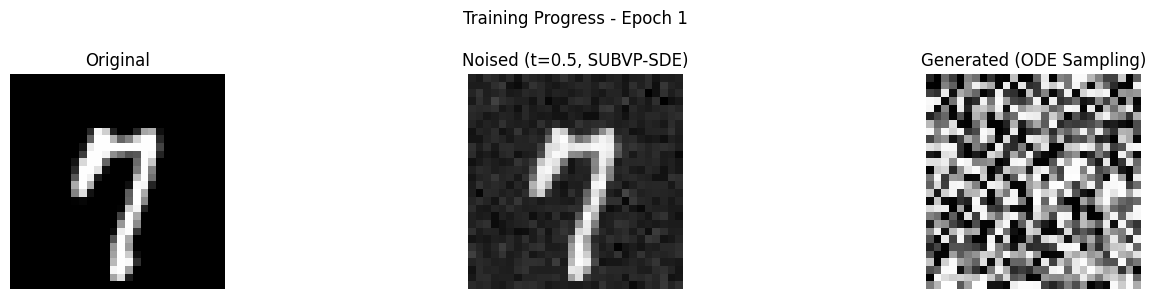

Epoch 2 of 75
  Step 0/234 | Raw Loss: 0.157475
  Step 58/234 | Raw Loss: 0.141607
  Step 116/234 | Raw Loss: 0.128922
  Step 174/234 | Raw Loss: 0.126150
  Step 232/234 | Raw Loss: 0.126109
  Epoch 2 average loss: 0.136376
Epoch 3 of 75
  Step 0/234 | Raw Loss: 0.124691
  Step 58/234 | Raw Loss: 0.119001
  Step 116/234 | Raw Loss: 0.118096
  Step 174/234 | Raw Loss: 0.114350
  Step 232/234 | Raw Loss: 0.109956
  Epoch 3 average loss: 0.119216
Epoch 4 of 75
  Step 0/234 | Raw Loss: 0.117315
  Step 58/234 | Raw Loss: 0.111719
  Step 116/234 | Raw Loss: 0.113876
  Step 174/234 | Raw Loss: 0.113717
  Step 232/234 | Raw Loss: 0.110457
  Epoch 4 average loss: 0.112320
Epoch 5 of 75
  Step 0/234 | Raw Loss: 0.110574
  Step 58/234 | Raw Loss: 0.111738
  Step 116/234 | Raw Loss: 0.104494
  Step 174/234 | Raw Loss: 0.110007
  Step 232/234 | Raw Loss: 0.110720
  Epoch 5 average loss: 0.108422
Visualizing progress at epoch 5...


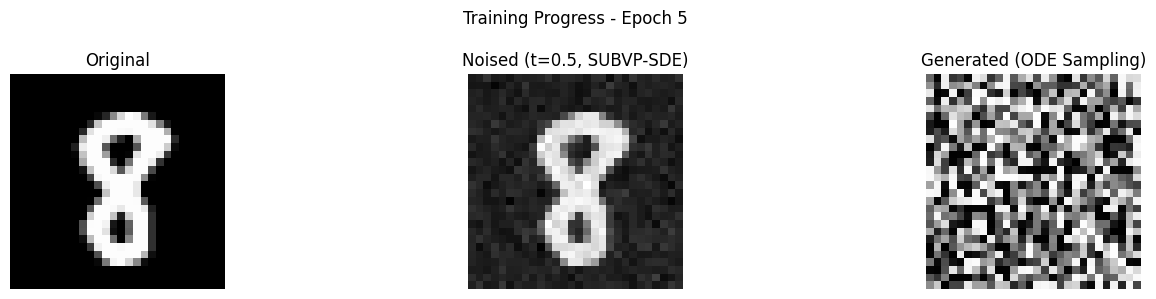

Epoch 6 of 75
  Step 0/234 | Raw Loss: 0.107566
  Step 58/234 | Raw Loss: 0.110984
  Step 116/234 | Raw Loss: 0.104013
  Step 174/234 | Raw Loss: 0.105905
  Step 232/234 | Raw Loss: 0.105552
  Epoch 6 average loss: 0.108453
Epoch 7 of 75
  Step 0/234 | Raw Loss: 0.108659
  Step 58/234 | Raw Loss: 0.110920
  Step 116/234 | Raw Loss: 0.108194
  Step 174/234 | Raw Loss: 0.095344
  Step 232/234 | Raw Loss: 0.100778
  Epoch 7 average loss: 0.105639
Epoch 8 of 75
  Step 0/234 | Raw Loss: 0.101744
  Step 58/234 | Raw Loss: 0.102492
  Step 116/234 | Raw Loss: 0.102639
  Step 174/234 | Raw Loss: 0.101467
  Step 232/234 | Raw Loss: 0.103060
  Epoch 8 average loss: 0.104221
Epoch 9 of 75
  Step 0/234 | Raw Loss: 0.102468
  Step 58/234 | Raw Loss: 0.103023
  Step 116/234 | Raw Loss: 0.100971
  Step 174/234 | Raw Loss: 0.107432
  Step 232/234 | Raw Loss: 0.099741
  Epoch 9 average loss: 0.103922
Epoch 10 of 75
  Step 0/234 | Raw Loss: 0.098847
  Step 58/234 | Raw Loss: 0.105060
  Step 116/234 | Raw

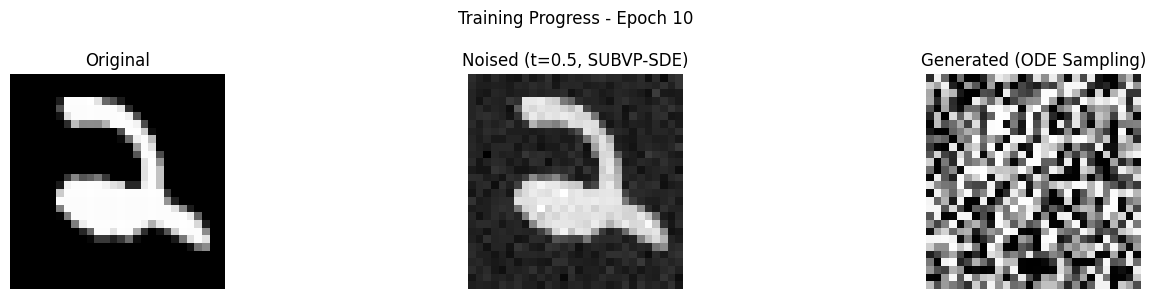

Epoch 11 of 75
  Step 0/234 | Raw Loss: 0.103607
  Step 58/234 | Raw Loss: 0.100276
  Step 116/234 | Raw Loss: 0.102265
  Step 174/234 | Raw Loss: 0.105086
  Step 232/234 | Raw Loss: 0.103249
  Epoch 11 average loss: 0.100856
Epoch 12 of 75
  Step 0/234 | Raw Loss: 0.097139
  Step 58/234 | Raw Loss: 0.101527
  Step 116/234 | Raw Loss: 0.102588
  Step 174/234 | Raw Loss: 0.099118
  Step 232/234 | Raw Loss: 0.102205
  Epoch 12 average loss: 0.101472
Epoch 13 of 75
  Step 0/234 | Raw Loss: 0.101474
  Step 58/234 | Raw Loss: 0.097941


KeyboardInterrupt: 

In [15]:
import os
from torch.optim import Adam

# Create checkpoint directory if it doesn't exist
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Check for MPS (Metal Performance Shaders) for Mac with Apple Silicon
if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda"
    print("Using CUDA")
else:
    device = "cpu"
    print("Using CPU")

# Initialize model with chosen SDE type
sde_type = "subvp"  # Options: "ve", "vp", "subvp"
model = ScoreUnet(device=device, sde_type=sde_type)
model.to(device)

# Setup optimizer
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 75  # Try more for better results!

# Checkpoint frequency
checkpoint_every = 10  # Save checkpoint every 10 epochs

# Resume from checkpoint if available
start_epoch = 0
latest_checkpoint = None

# Find the latest checkpoint
checkpoint_files = [
    f
    for f in os.listdir(checkpoint_dir)
    if f.startswith(f"score_diffusion_{sde_type}_") and f.endswith(".pt")
]
if checkpoint_files:
    # Extract epoch numbers from filenames
    checkpoint_epochs = [int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files]
    if checkpoint_epochs:
        latest_epoch = max(checkpoint_epochs)
        latest_checkpoint = f"score_diffusion_{sde_type}_epoch_{latest_epoch}.pt"

        # Load the checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1

        print(f"Resuming from checkpoint: {latest_checkpoint} (epoch {start_epoch})")

# Training loop
for epoch in range(start_epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    epoch_loss = 0.0
    num_batches = 0

    # Iterate over the dataloader
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # Get batch of images
        x_0 = prepare_batch(batch, device)

        # Sample random continuous times in [0,1]
        t = torch.rand(x_0.shape[0], device=device)

        # Compute loss using the simplified loss function
        loss = loss_function(model, x_0, t, sde_type=sde_type, device=device)

        # Print loss before backprop for debugging
        if step % 58 == 0:
            print(f"  Step {step}/{len(dataloader)} | Raw Loss: {loss.item():.6f}")

        # Backpropagation
        loss.backward()

        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Add to epoch totals - MAKE SURE THESE LINES ARE INCLUDED
        epoch_loss += loss.item()
        num_batches += 1

    # Print epoch summary
    avg_loss = epoch_loss / num_batches
    print(f"  Epoch {epoch+1} average loss: {avg_loss:.6f}")

    # Save checkpoint
    if (epoch + 1) % checkpoint_every == 0:
        checkpoint_path = os.path.join(
            checkpoint_dir, f"score_diffusion_{sde_type}_epoch_{epoch+1}.pt"
        )
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved: {checkpoint_path}")

    # Visualize progress every few epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Visualizing progress at epoch {epoch+1}...")

        # Show training progress
        training_progress_visualization(
            model,
            dataloader,
            epoch + 1,
            sde_type=sde_type,
            method="ode",  # Use ODE sampler for faster visualization
            device=device,
        )

        # Generate a grid of samples
        if (epoch + 1) % 15 == 0 or epoch == epochs - 1:
            generate_grid(
                model,
                sde_type=sde_type,
                method="ode",
                num_samples=16,
                num_steps=100,
                device=device,
            )

# Final visualization with both sampling methods
print("Training complete! Generating final samples...")

# Generate samples with ODE solver (deterministic, faster)
print("Generating samples with ODE solver...")
sample_and_visualize(
    model, sde_type=sde_type, method="ode", num_steps=100, device=device
)

# Generate samples with SDE solver (stochastic)
print("Generating samples with SDE solver...")
sample_and_visualize(
    model, sde_type=sde_type, method="sde", num_steps=100, device=device
)

# Save the final model
final_model_path = f"score_diffusion_mnist_{sde_type}_final.pt"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as {final_model_path}")

# IT WORKS !! 🎉


In [ ]:
sample_plot_image()

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os


@torch.no_grad()
def create_diffusion_video(
    filename="diffusion_video.mp4", fps=30, dpi=150, show_every=1, grid=None
):
    """
    Creates a video showing the diffusion process from noise to coherent image.
    Optionally arranges multiple diffusion processes in a grid layout.

    Args:
        filename: Output video filename (should end with .mp4)
        fps: Frames per second in the output video
        dpi: Resolution of the output video
        show_every: Only include every Nth step (to reduce video size)
        grid: Optional tuple (rows, cols) to create a grid of diffusion processes.
              If None, creates a single video.

    Returns:
        Path to the saved video file
    """
    # Determine if we're making a grid or single video
    if grid is None:
        rows, cols = 1, 1
    else:
        rows, cols = grid

    # Set up figure with the right size and layout
    if rows == 1 and cols == 1:
        fig, axes = plt.subplots(figsize=(6, 7))  # Extra height for the title
        axes = np.array([[axes]])  # Make it a 2D array for consistent indexing
    else:
        fig, axes = plt.subplots(
            rows, cols, figsize=(cols * 3, rows * 3 + 1)
        )  # Extra height for the title
        if rows == 1:
            axes = axes.reshape(1, cols)
        elif cols == 1:
            axes = axes.reshape(rows, 1)

    # Remove ticks from all subplots
    for r in range(rows):
        for c in range(cols):
            axes[r, c].set_xticks([])
            axes[r, c].set_yticks([])

    # Add adequate padding to make room for the title
    plt.subplots_adjust(top=0.85)  # Move subplots down to make room for title

    # Start with random noise for each grid position
    img_size = IMG_SIZE
    grid_images = []
    for r in range(rows):
        for c in range(cols):
            # Create a random seed image
            img = torch.randn((1, 1, img_size, img_size), device=device)
            grid_images.append(img)

    # Store all frames for the animation
    all_frames = []

    print(
        f"Generating {T//show_every} frames for {'single image' if grid is None else f'{rows}x{cols} grid'}..."
    )

    # Run the reverse diffusion process for all images
    for i in range(T - 1, -1, -1):
        # Only capture frames at specified intervals
        if i % show_every == 0:
            # Create a frame showing the current state of all images
            frame_data = []

            for idx, img in enumerate(grid_images):
                r, c = divmod(idx, cols)

                # Get current state of this image
                display_img = img[0].detach().cpu()
                if display_img.shape[0] == 1:  # Handle grayscale
                    display_img = display_img.squeeze(0)

                # Convert to numpy and scale to [0,1]
                display_img = (display_img + 1) / 2
                display_img = display_img.numpy()

                # Store for this frame
                frame_data.append((r, c, display_img))

            # Add the step number
            all_frames.append((frame_data, f"Diffusion Process - Step {T-i}/{T}"))

        # Now perform denoising step for all images
        for idx in range(len(grid_images)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            grid_images[idx] = sample_timestep(grid_images[idx], t)
            grid_images[idx] = torch.clamp(grid_images[idx], -1.0, 1.0)

        # Show progress
        if i % 50 == 0:
            print(f"Processed step {T-i}/{T}")

    # Make sure to include the final state
    final_frame_data = []
    for idx, img in enumerate(grid_images):
        r, c = divmod(idx, cols)
        display_img = img[0].detach().cpu()
        if display_img.shape[0] == 1:
            display_img = display_img.squeeze(0)
        display_img = (display_img + 1) / 2
        display_img = display_img.numpy()
        final_frame_data.append((r, c, display_img))

    all_frames.append((final_frame_data, "Final Result"))

    print(f"Captured {len(all_frames)} frames. Creating animation...")

    # Set up the animation
    def init():
        for r in range(rows):
            for c in range(cols):
                axes[r, c].clear()
                axes[r, c].set_xticks([])
                axes[r, c].set_yticks([])
        # Remove any existing title
        if hasattr(fig, "_suptitle") and fig._suptitle is not None:
            fig._suptitle.set_text("")
        return []

    def animate(i):
        grid_data, title = all_frames[i]

        # Update all grid positions
        for r, c, img_data in grid_data:
            axes[r, c].clear()
            axes[r, c].imshow(img_data, cmap="gray")
            axes[r, c].set_xticks([])
            axes[r, c].set_yticks([])

            # Add individual titles if it's a grid
            if rows > 1 or cols > 1:
                idx = r * cols + c
                axes[r, c].set_title(f"Sample {idx+1}")

        # Add a global title that's clearly visible
        fig.suptitle(title, fontsize=16, y=0.98)

        return []

    # Create animation
    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=len(all_frames),
        interval=1000 / fps,
        blit=False,
    )  # blit=False ensures title updates properly

    # Save animation
    print(f"Saving video to {filename}...")
    writer = animation.FFMpegWriter(
        fps=fps, metadata=dict(artist="Diffusion Model"), bitrate=3600
    )
    anim.save(filename, writer=writer, dpi=dpi)

    plt.close()
    print(f"Video saved successfully to {filename}")

    return filename


# Alternative version that generates frames instead of animation
@torch.no_grad()
def create_diffusion_frames(output_dir="diffusion_frames", show_every=1, grid=None):
    """
    Saves individual frames of the diffusion process(es).

    Args:
        output_dir: Directory to save the frames
        show_every: Only save every Nth frame
        grid: Optional tuple (rows, cols) to create a grid of diffusion processes.
              If None, creates frames for a single diffusion process.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Determine if we're making a grid or single video
    if grid is None:
        rows, cols = 1, 1
    else:
        rows, cols = grid

    # Start with random noise for each grid position
    img_size = IMG_SIZE
    grid_images = []
    for r in range(rows):
        for c in range(cols):
            img = torch.randn((1, 1, img_size, img_size), device=device)
            grid_images.append(img)

    frame_count = 0

    # Run the reverse diffusion process
    for i in range(T - 1, -1, -1):
        if i % show_every == 0:
            # Create a figure with appropriate layout
            if rows == 1 and cols == 1:
                fig, axes = plt.subplots(figsize=(6, 7))
                axes = np.array([[axes]])
            else:
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3 + 1))
                if rows == 1:
                    axes = axes.reshape(1, cols)
                elif cols == 1:
                    axes = axes.reshape(rows, 1)

            plt.subplots_adjust(top=0.85)  # Make room for the title

            # Update each subplot with current image state
            for idx, img in enumerate(grid_images):
                r, c = divmod(idx, cols)

                display_img = img[0].detach().cpu()
                if display_img.shape[0] == 1:
                    display_img = display_img.squeeze(0)
                display_img = (display_img + 1) / 2
                display_img = display_img.numpy()

                axes[r, c].imshow(display_img, cmap="gray")
                if rows > 1 or cols > 1:
                    axes[r, c].set_title(f"Sample {idx+1}")
                axes[r, c].set_xticks([])
                axes[r, c].set_yticks([])

            # Add a global title
            fig.suptitle(f"Diffusion Process - Step {T-i}/{T}", fontsize=16, y=0.98)

            # Save the frame
            frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
            plt.savefig(frame_path, dpi=150, bbox_inches="tight")
            plt.close(fig)

            frame_count += 1

            if frame_count % 10 == 0:
                print(f"Saved {frame_count} frames")

        # Now perform denoising step for all images
        for idx in range(len(grid_images)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            grid_images[idx] = sample_timestep(grid_images[idx], t)
            grid_images[idx] = torch.clamp(grid_images[idx], -1.0, 1.0)

    # Save final frame
    if rows == 1 and cols == 1:
        fig, axes = plt.subplots(figsize=(6, 7))
        axes = np.array([[axes]])
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3 + 1))
        if rows == 1:
            axes = axes.reshape(1, cols)
        elif cols == 1:
            axes = axes.reshape(rows, 1)

    plt.subplots_adjust(top=0.85)

    for idx, img in enumerate(grid_images):
        r, c = divmod(idx, cols)
        display_img = img[0].detach().cpu()
        if display_img.shape[0] == 1:
            display_img = display_img.squeeze(0)
        display_img = (display_img + 1) / 2
        display_img = display_img.numpy()

        axes[r, c].imshow(display_img, cmap="gray")
        if rows > 1 or cols > 1:
            axes[r, c].set_title(f"Sample {idx+1}")
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    fig.suptitle("Final Result", fontsize=16, y=0.98)

    frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
    plt.savefig(frame_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved {frame_count+1} frames to {output_dir}")
    print("You can combine these frames into a video using FFmpeg:")
    print(
        f"ffmpeg -framerate 30 -i {output_dir}/frame_%04d.png -c:v libx264 -pix_fmt yuv420p diffusion_video.mp4"
    )

    return output_dir

In [ ]:
create_diffusion_video(grid=(4, 4), show_every=3)

In [ ]:
from IPython.display import HTML

HTML(
    """
    <video alt="test" controls>
        <source src="diffusion_video.mp4" type="video/mp4" width=500>
    </video>
"""
)